# Prática 7

Aprendizado Dinâmico

por Cibele Russo (ICMC/USP - São Carlos SP)

MBA em Ciências de Dados



**1.Faça a leitura das bibliotecas.**

Nesta prática vamos considerar redes dinâmicas para modelar a temperatura global dos dados em globaltemp.

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

**2. Leia os dados do arquivo globaltemp.csv.**

<AxesSubplot:xlabel='year'>

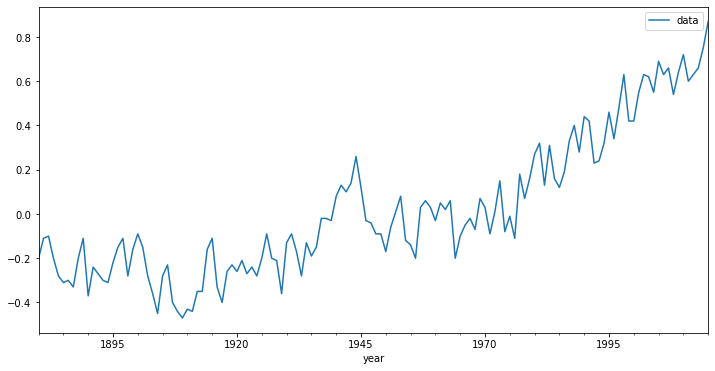

In [2]:
# Temperatura global

# Diferenças na média de temperatura global. 
# Fonte: https://github.com/mjuez/pytsdatasets/

pkgdir = 'dados'
# pkgdir = '/hdd/MBA/AprendizadoDinamico/Data'


df = pd.read_csv(f'{pkgdir}/globaltemp.csv', index_col=0,
                         parse_dates=True)
df.index = df.index
df.plot(figsize=(12,6))


In [3]:
df.head()

,data
year,
1880-01-01,-0.20
1881-01-01,-0.11
1882-01-01,-0.10
1883-01-01,-0.20
1884-01-01,-0.28


##

**3.  Divida a base em treino e teste, deixando 14 dias para a previsão.**

In [4]:
len(df)

136

In [5]:
len(df)-14


122

In [6]:
train = df.iloc[:122]
test = df.iloc[122:]

In [7]:
train

,data
year,
1880-01-01,-0.20
1881-01-01,-0.11
1882-01-01,-0.10
1883-01-01,-0.20
1884-01-01,-0.28
...,...
1997-01-01,0.48
1998-01-01,0.63
1999-01-01,0.42


**4. Padronize os dados para a modelagem.**

In [8]:
from sklearn.preprocessing import MinMaxScaler

In [9]:
scaler = MinMaxScaler()

In [10]:
scaler.fit(train)

MinMaxScaler()

In [11]:
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

**5. Considere o gerador de séries temporais, com variados valores para os parâmetros length e batch_size.**


In [12]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [13]:
# defina o gerador
n_input = 2
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [14]:
len(scaled_train)

122

In [15]:
len(generator) # n_input = 2

120

In [16]:
# Qual é a aparência do primeiro lote?
X,y = generator[0]

In [17]:
print(f'Dado o array: \n{X.flatten()}');
print(f'Previsão: \n {y}');

Dado o array: 
[0.24545455 0.32727273]
Previsão: 
 [[0.33636364]]


**6. Carregue as bibliotecas do keras para as redes dinâmicas.**

In [18]:
### Pacote ideal do tensorflow = 2.5
### Pacote ideal do keras = 2.6
### Caso necessário, instale o pacote nessas versões

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

**7. Defina os lotes pra o processo iterativo.**

In [19]:
# Vamos redefinir lotes de tamanho 21 para o procedimento iterativo
# Veja mais informações sobre o tamanho do lote http://deeplearningbook.com.br/o-efeito-do-batch-size-no-treinamento-de-redes-neurais-artificiais/

n_input = 7
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

**8. Defina o modelo. Ele pode ter uma camada LSTM e uma camada Dense. Teste alternativas.**

In [20]:
# Defina o modelo
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               40800     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


**9. Faça o ajuste do modelo e observe a função de perda.**

In [22]:
# Ajuste do modelo

model.fit_generator(generator,epochs=100)

C:\Users\joaop\anaconda3\lib\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
115/115 [==============================] - 2s 3ms/step - loss: 0.0481
Epoch 2/100
115/115 [==============================] - 0s 3ms/step - loss: 0.0170
Epoch 3/100
115/115 [==============================] - 0s 3ms/step - loss: 0.0124
Epoch 4/100
115/115 [==============================] - 0s 3ms/step - loss: 0.0123
Epoch 5/100
115/115 [==============================] - 0s 3ms/step - loss: 0.0142
Epoch 6/100
115/115 [==============================] - 0s 3ms/step - loss: 0.0123
Epoch 7/100
115/115 [==============================] - 0s 3ms/step - loss: 0.0118
Epoch 8/100
115/115 [==============================] - 0s 3ms/step - loss: 0.0111
Epoch 9/100
115/115 [==============================] - 0s 3ms/step - loss: 0.0119
Epoch 10/100
115/115 [==============================] - 0s 3ms/step - loss: 0.0126
Epoch 11/100
115/115 [==============================] - 0s 3ms/step - loss: 0.0124
Epoch 12/100
115/115 [==============================] - 0s 3ms/step - loss: 0.0117
Epoch 13/100


115/115 [==============================] - 0s 3ms/step - loss: 0.0078
Epoch 100/100
115/115 [==============================] - 0s 4ms/step - loss: 0.0077


In [23]:
model.history.history.keys()

dict_keys(['loss'])

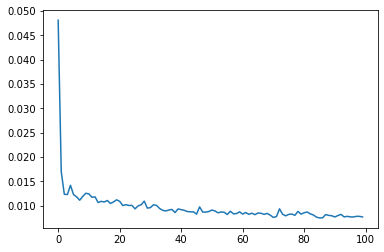

In [24]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

**10. Faça a previsão.**

In [25]:
# Vejamos passo a passo como é feita a previsão, a princípio para a próxima observação usando o tamanho do lote igual a 7

first_eval_batch = scaled_train[-7:]

In [26]:
first_eval_batch

array([[0.84545455],
       [0.73636364],
       [0.86363636],
       [1.        ],
       [0.80909091],
       [0.80909091],
       [0.92727273]])

In [27]:
# Agora vamos considerar as previsões para as próximas 21 observações e comparar com a base de teste

test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    
    # obter a previsão de tempo 1 antecipadamente ([0] é para pegar apenas o número em vez de [array])
    current_pred = model.predict(current_batch)[0]
    
    # predição
    test_predictions.append(current_pred) 
    
    # atualize a rodada para agora incluir a previsão e descartar o primeiro valor
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [28]:
test_predictions

[array([1.0321599], dtype=float32),
 array([0.9699081], dtype=float32),
 array([1.1054372], dtype=float32),
 array([1.3420792], dtype=float32),
 array([1.2143881], dtype=float32),
 array([1.2041112], dtype=float32),
 array([1.3452823], dtype=float32),
 array([1.5275304], dtype=float32),
 array([1.5399729], dtype=float32),
 array([1.814335], dtype=float32),
 array([2.326639], dtype=float32),
 array([2.3588493], dtype=float32),
 array([2.3700812], dtype=float32),
 array([2.6609428], dtype=float32)]

In [29]:
scaled_test

array([[1.        ],
       [0.99090909],
       [0.92727273],
       [1.05454545],
       [1.        ],
       [1.02727273],
       [0.91818182],
       [1.00909091],
       [1.08181818],
       [0.97272727],
       [1.        ],
       [1.02727273],
       [1.10909091],
       [1.21818182]])

**11. Retorne da padronização.**

In [30]:
true_predictions = scaler.inverse_transform(test_predictions)

In [31]:
true_predictions

array([[0.66537592],
       [0.59689893],
       [0.74598088],
       [1.00628708],
       [0.86582695],
       [0.85452234],
       [1.00981055],
       [1.21028347],
       [1.22397019],
       [1.52576849],
       [2.08930283],
       [2.12473422],
       [2.1370893 ],
       [2.45703707]])

In [32]:
# Possivelmente encontraremos warnings aqui
test['Predictions'] = true_predictions

<ipython-input-32-b5be589fc0d6>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = true_predictions


**12. Visualize os resultados, comparando as previsões com a base de teste.**

<AxesSubplot:xlabel='year'>

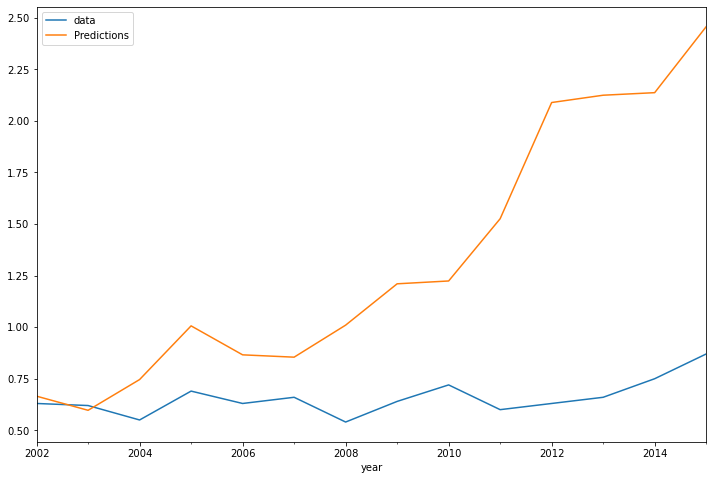

In [33]:

test.plot(figsize=(12,8))